In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [1]:
from datasets import load_from_disk

In [2]:
ds = load_from_disk("/media/gagan/Gagan_external/songbird_data/hf_dataset/dataset_0/")

In [3]:
len(ds)

20000

In [4]:
ds

Dataset({
    features: ['bird_name', 'recording_date', 'days_post_hatch', 'filename', 'audio', 'spectrogram', 'sample_rate', 'n_fft', 'win_length', 'hop_length', 'tutor_name', 'tutoring_start_dph', 'tutored'],
    num_rows: 20000
})

In [7]:
S = np.array(ds[0]["spectrogram"])

In [8]:
S.shape

(129, 189)

In [9]:
import matplotlib.pyplot as plt 

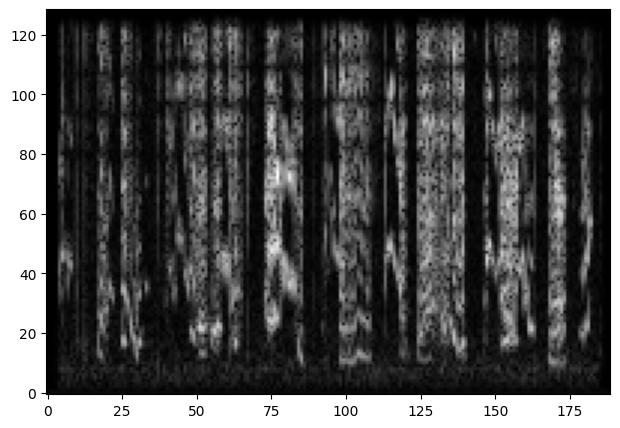

In [19]:
plt.figure(figsize=(5,15))
plt.imshow(np.log10(S + 1e-2), origin="lower", cmap="gray")

In [1]:
import os
import glob

In [6]:
names = sorted(glob.glob("/media/gagan/Gagan_external/songbird_data/WAV_files/b3g20/SAP/20*"))

In [ ]:
names

# Test new dataset

In [1]:
from birdsong_gan.data.hf_dataset import BirdsongHFDataset

In [3]:
ds = BirdsongHFDataset(path_to_dataset="/media/gagan/Gagan_external/songbird_data/hf_dataset/", verbose=True, generate_labels=True,
                       label_column="days_post_hatch", feature_column="spectrogram")

In [5]:
len(ds)

1520000

In [6]:
ds.features

{'bird_name': Value(dtype='string', id=None),
 'recording_date': Value(dtype='string', id=None),
 'days_post_hatch': Value(dtype='int64', id=None),
 'filename': Value(dtype='string', id=None),
 'audio': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'spectrogram': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
 'sample_rate': Value(dtype='int64', id=None),
 'n_fft': Value(dtype='int64', id=None),
 'win_length': Value(dtype='int64', id=None),
 'hop_length': Value(dtype='int64', id=None),
 'tutor_name': Value(dtype='string', id=None),
 'tutoring_start_dph': Value(dtype='int64', id=None),
 'tutored': Value(dtype='bool', id=None)}

### tests 

In [19]:
bird_ds = ds.get_single_bird_dataset("b3g20")

In [21]:
len(bird_ds)

146513

In [26]:
ex = bird_ds.get_ds_items([0,-1])

In [29]:
ex["bird_name"]

['b3g20', 'b3g20']

In [45]:
bird_ds.verbose=True

In [46]:
resample_ds = bird_ds.get_age_resampled_dataset(max_samples_per_age=2000)

Resampling dataset. New max samples per age: 2000, new min samples per user: 1
Number of unique age:  77
Max samples per age:  3178
Min samples per age:  419
Mean samples per age:  1902.7662337662337
Median samples per age:  1926.0
Number of ages that make up 50% of the data:  37


In [47]:
len(resample_ds)

129842

In [48]:
ages = np.array(bird_ds.get_ds_items("days_post_hatch"))

In [49]:
len(ages)

146513

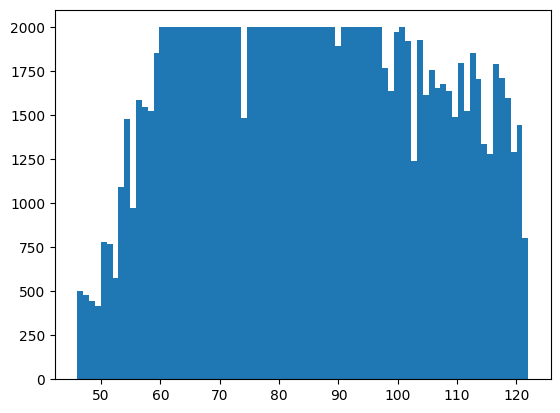

In [55]:
plt.figure()
plt.hist(ages, bins=77)
plt.show()

In [51]:
ages = np.array(resample_ds.get_ds_items("days_post_hatch"))

In [52]:
len(ages)

129842

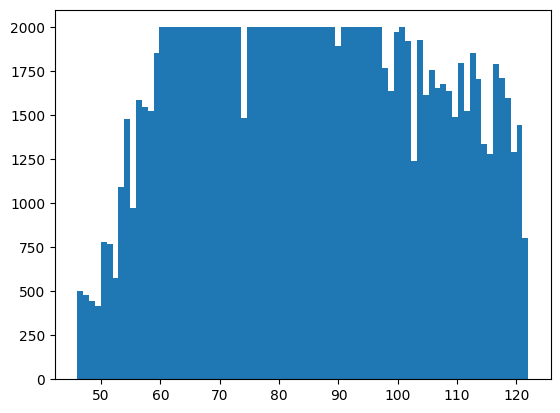

In [54]:
plt.figure()
plt.hist(ages, bins=77)
plt.show()

# Export files after age resampling

## first filter the dataset till a max age because some birds can be older

In [10]:
all_ages = np.array(ds.get_ds_items("days_post_hatch"))

In [11]:
len(all_ages)

1520000

In [12]:
subset_ids = np.where(all_ages <= 90)[0]
len(subset_ids)

1321515

In [13]:
ds_sub = ds.subset(subset_ids)

In [14]:
len(ds_sub)

1321515

In [16]:
ages = np.array(ds_sub.get_ds_items("days_post_hatch"))

In [18]:
np.min(ages[ages > -1])

37

In [19]:
np.max(ages[ages > -1])

90

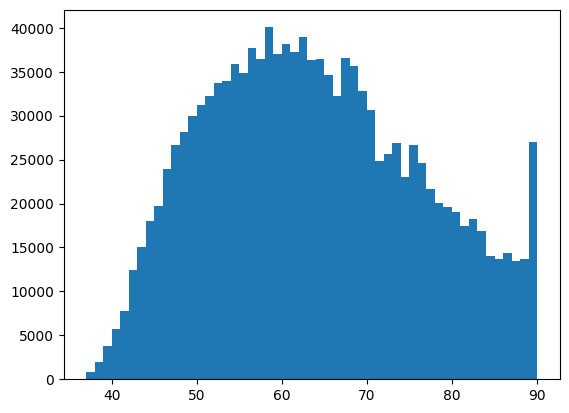

In [21]:
plt.figure()
plt.hist(ages[ages > -1], bins=53)
plt.show()

In [22]:
age_resample_ds =  ds_sub.get_age_resampled_dataset(max_samples_per_age=10000)

Resampling dataset. New max samples per age: 10000, new min samples per age: 1
Number of unique age:  55
Max samples per age:  40060
Min samples per age:  827
Mean samples per age:  24027.545454545456
Median samples per age:  24879.0
Number of ages that make up 50% of the data:  26


In [23]:
resampled_ages = np.array(age_resample_ds.get_ds_items("days_post_hatch"))

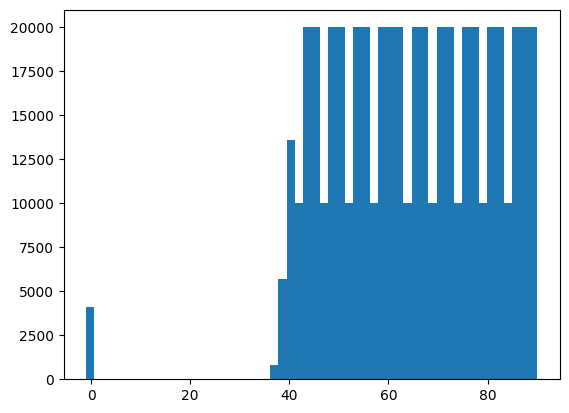

In [26]:
plt.figure()
plt.hist(resampled_ages, bins=54)
plt.show()

In [28]:
ex = age_resample_ds.get_ds_items([0,1])

In [29]:
ex["filename"]

['b3g20D-f00233-2.wav', 'b3g20D-f00277-1.wav']

In [30]:
ex["recording_date"]

['tutor', 'tutor']

In [31]:
len(age_resample_ds)

514229

In [32]:
age_resample_ds.save_to_disk("/media/gagan/Gagan_external/songbird_data/age_resampled_hfdataset")

Saving the dataset (0/224 shards):   0%|          | 0/514229 [00:00<?, ? examples/s]

## export

In [33]:
import torch
import torchaudio

In [36]:
import pdb

In [41]:
def export_ds(dataset, output_folder):
    N = len(dataset)
    for i in range(N):
        filename = dataset.ds[i]["filename"]
        fname = filename.split(".wav")[0]
        fname = fname + "_" + dataset.ds[i]["recording_date"] + "_dph_" + str(dataset.ds[i]["days_post_hatch"]) + ".wav"
        # append recording 
        output_path = os.path.join(output_folder, fname)
        audio = torch.FloatTensor(dataset.ds[i]["audio"])
        torchaudio.save(output_path, audio.unsqueeze(0), sample_rate=16000)

        if (i + 1) % 500 == 0:
            print(f"Done with {i} / {N} files")

In [ ]:
export_ds(age_resample_ds, "/media/gagan/GNARULA_SSD/songbird_age_resampled_data_wavfiles/")

In [43]:
"a"

'a'

# Load saved metadata

In [49]:
import pandas as pd

In [53]:
df = pd.read_json("/media/gagan/GNARULA_SSD/songbird_experiments/encodec/data.jsonl.gz", lines=True, compression="gzip")

In [54]:
df.shape

(514229, 6)

In [55]:
df.head(3)

,path,duration,sample_rate,amplitude,weight,info_path
0,/media/gagan/GNARULA_SSD/songbird_age_resample...,1.284063,16000,NaN,NaN,NaN
1,/media/gagan/GNARULA_SSD/songbird_age_resample...,2.303313,16000,NaN,NaN,NaN
2,/media/gagan/GNARULA_SSD/songbird_age_resample...,2.275125,16000,NaN,NaN,NaN


In [56]:
df.path.iloc[0]

'/media/gagan/GNARULA_SSD/songbird_age_resampled_data_wavfiles/b13r16U-f00001-1_2011-05-04_dph_40.wav'

# Split metadata files into train, val and evaluate

In [57]:
train_ids = np.random.choice(len(df), size=int(0.8 * len(df)), replace=False)
val_ids = np.setdiff1d(np.arange(len(df)), train_ids)

In [58]:
eval_ids = np.random.choice(val_ids, size=int(0.5 * len(val_ids)), replace=False)
val_ids = np.setdiff1d(val_ids, eval_ids)

In [59]:
train_ids.shape

(411383,)

In [60]:
val_ids.shape

(51423,)

In [61]:
eval_ids.shape

(51423,)

In [62]:
np.intersect1d(train_ids, val_ids)

array([], dtype=int64)

In [63]:
np.intersect1d(eval_ids, val_ids)

array([], dtype=int64)

In [65]:
train_df = df.iloc[train_ids, :]
val_df = df.iloc[val_ids, :]
test_df = df.iloc[eval_ids, :]

In [66]:
train_df.to_json("/media/gagan/GNARULA_SSD/songbird_experiments/encodec/train_data.jsonl.gz", compression="gzip", lines=False)

In [67]:
val_df.to_json("/media/gagan/GNARULA_SSD/songbird_experiments/encodec/val_data.jsonl.gz", compression="gzip", lines=False)

In [68]:
test_df.to_json("/media/gagan/GNARULA_SSD/songbird_experiments/encodec/test_data.jsonl.gz", compression="gzip", lines=False)